# Using GraSPI

## Reproduce Previous Work

This notebook reproduces [an analysis from the original GraSPI package](https://github.com/owodolab/graspi/blob/ede5c1625cc95da438a3ba6e06291f8e0fd1c68b/examples/2phaseMorphologies/thinFilm/Report.pdf). The microstructure is generated by a Cahn-Hilliard simulation. The graph statistics are designed to characterize a photo-voltaic device. The upper boundary is an anode and the bottom boundary is a cathode. The yellow material is donor while the blue material is acceptor.

In [1]:
import pandas
import numpy as np
import dask.array as da
from dask.distributed import Client
from dask_ml.preprocessing import MinMaxScaler
from dask_ml.linear_model import LogisticRegression
from dask_ml.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import confusion_matrix
from toolz.curried import pipe, curry

from pymks import (
    solve_cahn_hilliard,
    plot_microstructures,
    graph_descriptors,
    GenericTransformer,
    GraphDescriptors
)

In [3]:
data = np.array(pandas.read_csv('data_0.528_3.8_000160.txt', delimiter=' ', header=None)).swapaxes(0, 1)

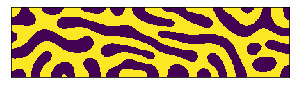

In [4]:
plot_microstructures(data.swapaxes(0, 1), colorbar=False)

In [5]:
data.shape

(401, 101)

`graph_descriptors` works with Numpy arrays. The extra dimension is required as PyMKS functions require a sample axis. When using Numpy arrays `graph_descriptors` will return an ordinary Pandas dataframe (not Dask). 

In [6]:
graph_descriptors(data.reshape((1,) + data.shape))

,n_vertices,n_edges,n_phase0,n_phase1,n_phase0_connect,n_phase1_connect,n_phase0_connect_top,n_phase1_connect_bottom,w_frac_phase0,frac_phase0,...,inter_frac_bottom_and_top,frac_phase0_top,frac_phase1_bottom,n_inter_paths,n_phase0_inter_top,n_phase1_inter_bottom,frac_phase0_rising,frac_phase1_rising,n_phase0_connect_anode,n_phase1_connect_cathode
0,40501,3698,19268,21233,22,5,9,3,0.298392,0.475741,...,0.296376,0.319545,0.979843,1096,1159,3668,0.522495,0.152944,207,196


## Generate Microstructures to Test Speed

Generate 144 microstructures to test speed with and without Dask

In [7]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

Client()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 62.52 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39731,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 62.52 GiB
Comm: tcp://127.0.0.1:45293,Total threads: 3
Dashboard: http://127.0.0.1:33383/status,Memory: 15.63 GiB
Nanny: tcp://127.0.0.1:46031,


Create 144 sample chunked into 6.

In [8]:
da.random.seed(99)

n_sample = 144
n_domain = 101
n_chunks = 24

x_data = (
    2 * da.random.random((n_sample, n_domain, n_domain), chunks=(n_chunks, n_domain, n_domain)) - 1
)
y_data = solve_cahn_hilliard(x_data, delta_t=1.0, n_steps=100, delta_x=0.5).persist()

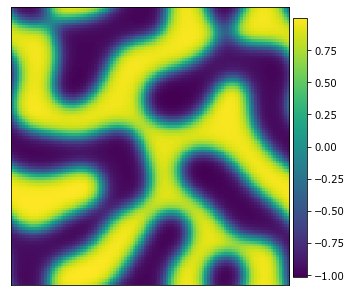

In [9]:
plot_microstructures(y_data[0])

The graph descriptors function requies data binned into either 0 or 1 phases

In [10]:
y_data_binned = da.where(y_data > 0, 1, 0).persist()
y_data_np = y_data_binned.compute()

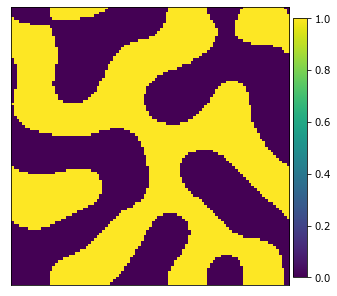

In [11]:
plot_microstructures(y_data_binned[0])

On a laptop the Dask version is almost 5 times faster. Note that the `graph_descriptors` function returns a Numpy or Dask array based on whether its passed a Numpy array or Dask array. Passing it a Numpy array will force it to work as one process and therefore will be slower.

In [12]:
#NBVAL_SKIP

%time out_pandas = graph_descriptors(y_data_np)

CPU times: user 539 ms, sys: 133 ms, total: 672 ms
Wall time: 17.9 s


In [13]:
#NBVAL_SKIP

%time graph_descriptors(y_data_binned).compute()

CPU times: user 237 ms, sys: 39.2 ms, total: 276 ms
Wall time: 5.05 s


,n_vertices,n_edges,n_phase0,n_phase1,n_phase0_connect,n_phase1_connect,n_phase0_connect_top,n_phase1_connect_bottom,w_frac_phase0,frac_phase0,...,inter_frac_bottom_and_top,frac_phase0_top,frac_phase1_bottom,n_inter_paths,n_phase0_inter_top,n_phase1_inter_bottom,frac_phase0_rising,frac_phase1_rising,n_phase0_connect_anode,n_phase1_connect_cathode
0,10201,927,5039,5162,4,2,2,2,0.311396,0.493971,...,0.437972,0.433022,1.000000,406,402,931,0.454629,0.148198,69,37
1,10201,951,5149,5052,3,4,1,1,0.326425,0.504754,...,0.179811,0.774325,0.480008,171,688,446,0.403812,0.246186,73,31
2,10201,907,5135,5066,3,3,2,2,0.305060,0.503382,...,0.127894,0.109056,0.897158,116,111,791,0.996429,0.049065,59,41
3,10201,942,5019,5182,4,1,2,1,0.307790,0.492011,...,0.695329,0.698346,1.000000,655,653,950,0.276177,0.131030,51,52
4,10201,917,5142,5059,3,4,2,3,0.317781,0.504068,...,0.731734,0.957021,0.783159,671,853,740,0.246698,0.220343,51,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,10201,959,5006,5195,5,2,1,1,0.313552,0.490736,...,0.259645,0.329604,0.959769,249,301,921,0.329091,0.181508,48,58
20,10201,991,5065,5136,4,1,2,1,0.309485,0.496520,...,0.501514,0.505429,1.000000,497,493,999,0.216016,0.125389,44,56
21,10201,944,5161,5040,2,4,1,2,0.317732,0.505931,...,0.739407,0.920364,0.868849,698,854,798,0.215579,0.356246,25,78
22,10201,941,5178,5023,3,4,2,2,0.323143,0.507597,...,0.676939,0.794515,0.942266,637,735,848,0.318182,0.227763,48,58


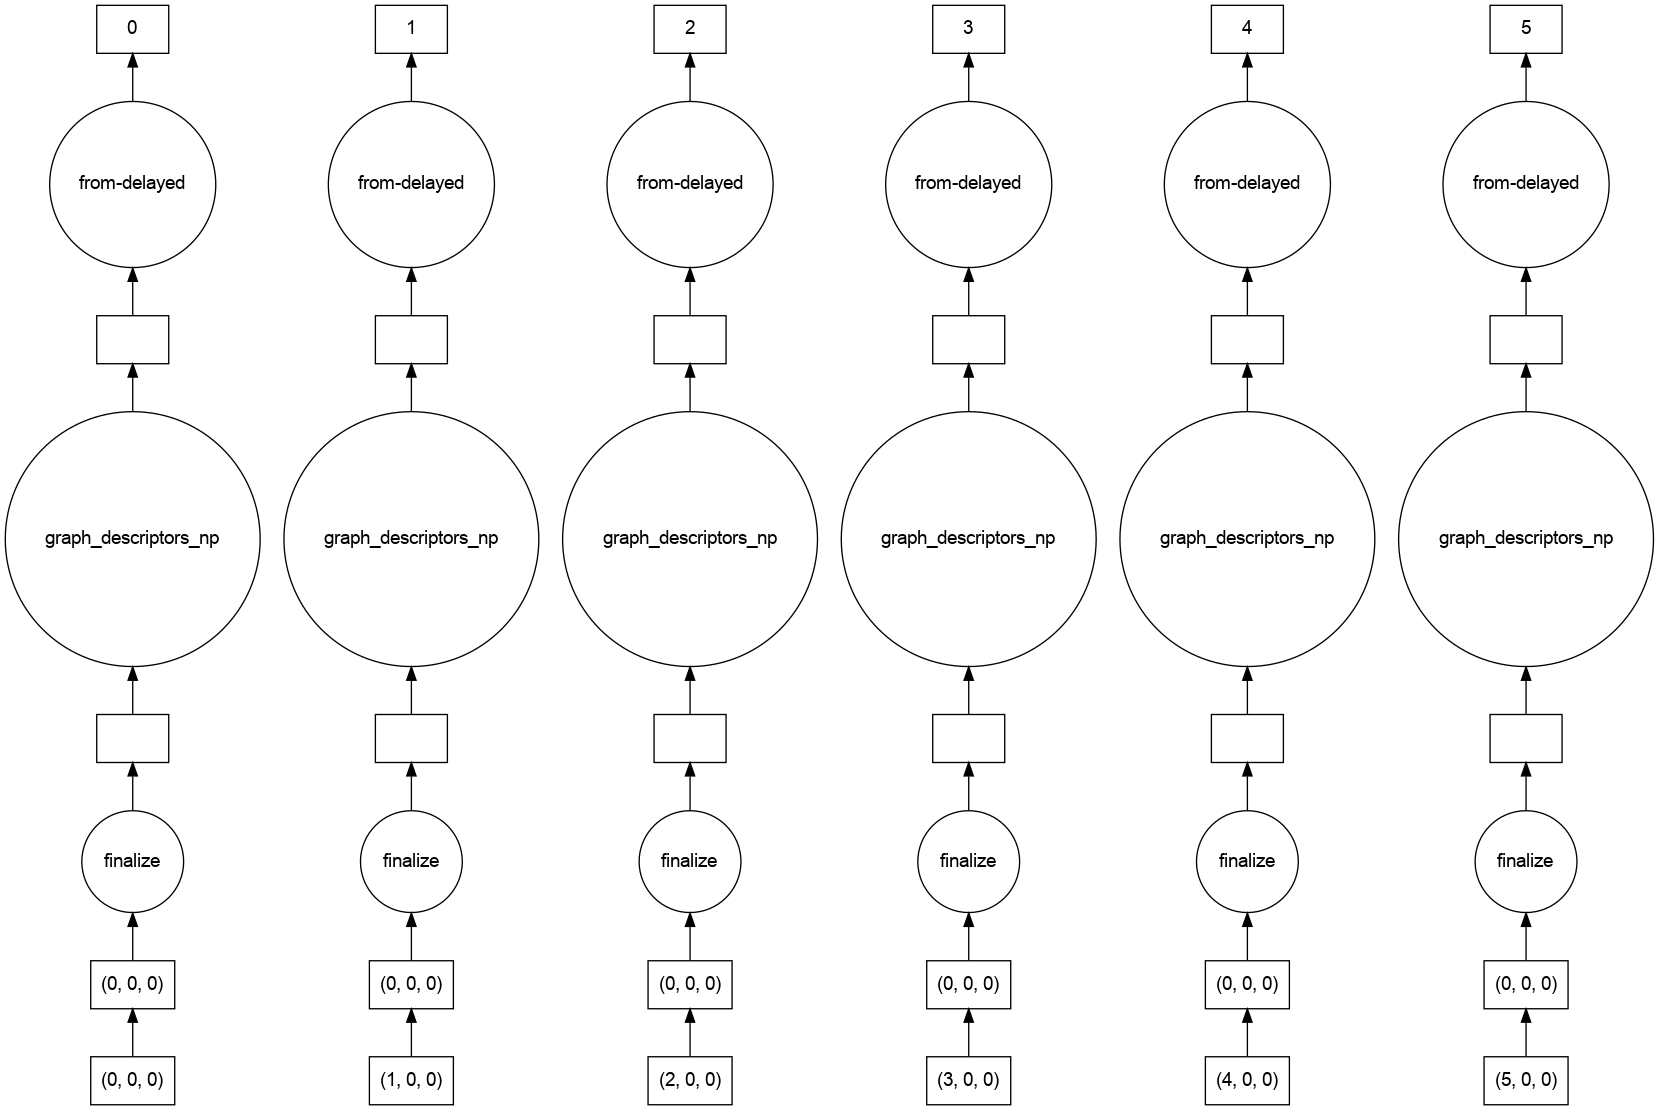

In [14]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

out = graph_descriptors(y_data_binned)
out.visualize()

In [15]:
#NBVAL_SKIP

from dask.distributed import performance_report

with performance_report(filename="dask-report.html"):
    out_pandas = out.compute()

In [16]:
#NBVAL_SKIP

import IPython
IPython.display.HTML(filename='dask-report.html')

## Using Pipelines 

Demonstrate how to use the graph descriptors as part of a machine learning pipeline. The `GraphDescriptors` object is a wrapper for the `graph_descriptors` function so that it works as part of a Scikit-learn pipeline.

Note that at this point it is a good idea to restart the notebook and only run the import cell and the `Client` cell above due to some memory issues.

The following generates 96 x 2 samples each with a different Cahn-Hilliard microstructure. The microstructures differ based on the time of evolution (10 steps versus 100 steps). This is not a particularly great machine learning example, but suffices to demonstrate using `GraphDescriptors` as part of a pipeline.

In [17]:
def generate_data(n_category, n_chunks, n_domain, seed=99):
    da.random.seed(seed)
    solve_ch = curry(solve_cahn_hilliard)(delta_t=1.0, delta_x=0.5)
    x_data = pipe(
        da.random.random((n_category * 2, n_domain, n_domain),
                         chunks=(n_chunks, n_domain, n_domain)),
        lambda x: 2 * x - 1,
        lambda x: [
            solve_ch(x[:n_category], n_steps=10),
            solve_ch(x[n_category:], n_steps=100)
        ],
        da.concatenate,
        lambda x: da.where(x > 0, 1, 0).persist()
    )
    y_data = da.from_array(
        np.concatenate([np.zeros(n_category), np.ones(n_category)]).astype(int),
        chunks=(n_chunks,)
    )
    return x_data, y_data

In [18]:
n_category = 96
n_chunks = 24
n_domain = 101

x_data, y_data = generate_data(n_category, n_chunks, n_domain)

For demonstration purposes the data is "persisted" in memory meaning that Dask has calculated the memory and stored in chunks on each worker.

In [19]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

x_data

dask.array<where, shape=(192, 101, 101), dtype=int64, chunksize=(24, 101, 101), chunktype=numpy.ndarray>

In [20]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

y_data

dask.array<array, shape=(192,), dtype=int64, chunksize=(24,), chunktype=numpy.ndarray>

The second category is more evolved.

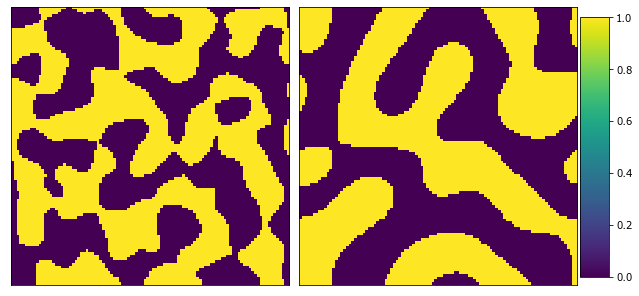

In [21]:
plot_microstructures(x_data[0], x_data[n_category])

The pipeline for fitting and predicting. The `GenericTransformer` allows to wrap simple transformer functions to reshape the data and remove unwanted features. The data needs to be flattened for use with `train_test_split` and then reshaped for use with `GraphDescriptors`. The `MinMaxSclaler` is used to rescale the graph descriptors feature to be between 0 and 1. Finally, `LogisticRegression` is used to classify the microstructures.

In [22]:
pipeline = Pipeline(steps=[
    ('reshape', GenericTransformer(lambda x: x.reshape(x.shape[0], n_domain, n_domain))),
    ('descriptors', GraphDescriptors()),
    ('normalizer', MinMaxScaler()),
    ('to_array', GenericTransformer(lambda x: x.to_dask_array(lengths=True))),
    ('remove_features', GenericTransformer(lambda x: x[:, 1:])),
    ('decision', LogisticRegression())
])

`train_test_split` requires the `x_data` to be shaped as `n_sample` x `n_features`. A 20% test size is used. 

In [23]:
x_train, x_test, y_train, y_test = train_test_split(
    x_data.reshape(x_data.shape[0], -1),
    y_data,
    test_size=0.2
)

Fit the data. There have been some unresolved memory leaks at this stage. As noted above, reset the notebook before running this final section.

In [24]:
# NBVAL_SKIP

pipeline.fit(x_train, y_train);

Make a prediction. `y_predict` is lazily evaluated so is an uncomputed Dask array at this stage. `compute` needs to be called to execute the prediction.

In [25]:
# NBVAL_SKIP

y_predict = pipeline.predict(x_test)

Seems to be a perfect prediction. 

In [26]:
# NBVAL_SKIP

confusion_matrix(y_test.compute(), y_predict.compute())

array([[20,  0],
       [ 0, 20]])

The entire prediction graph

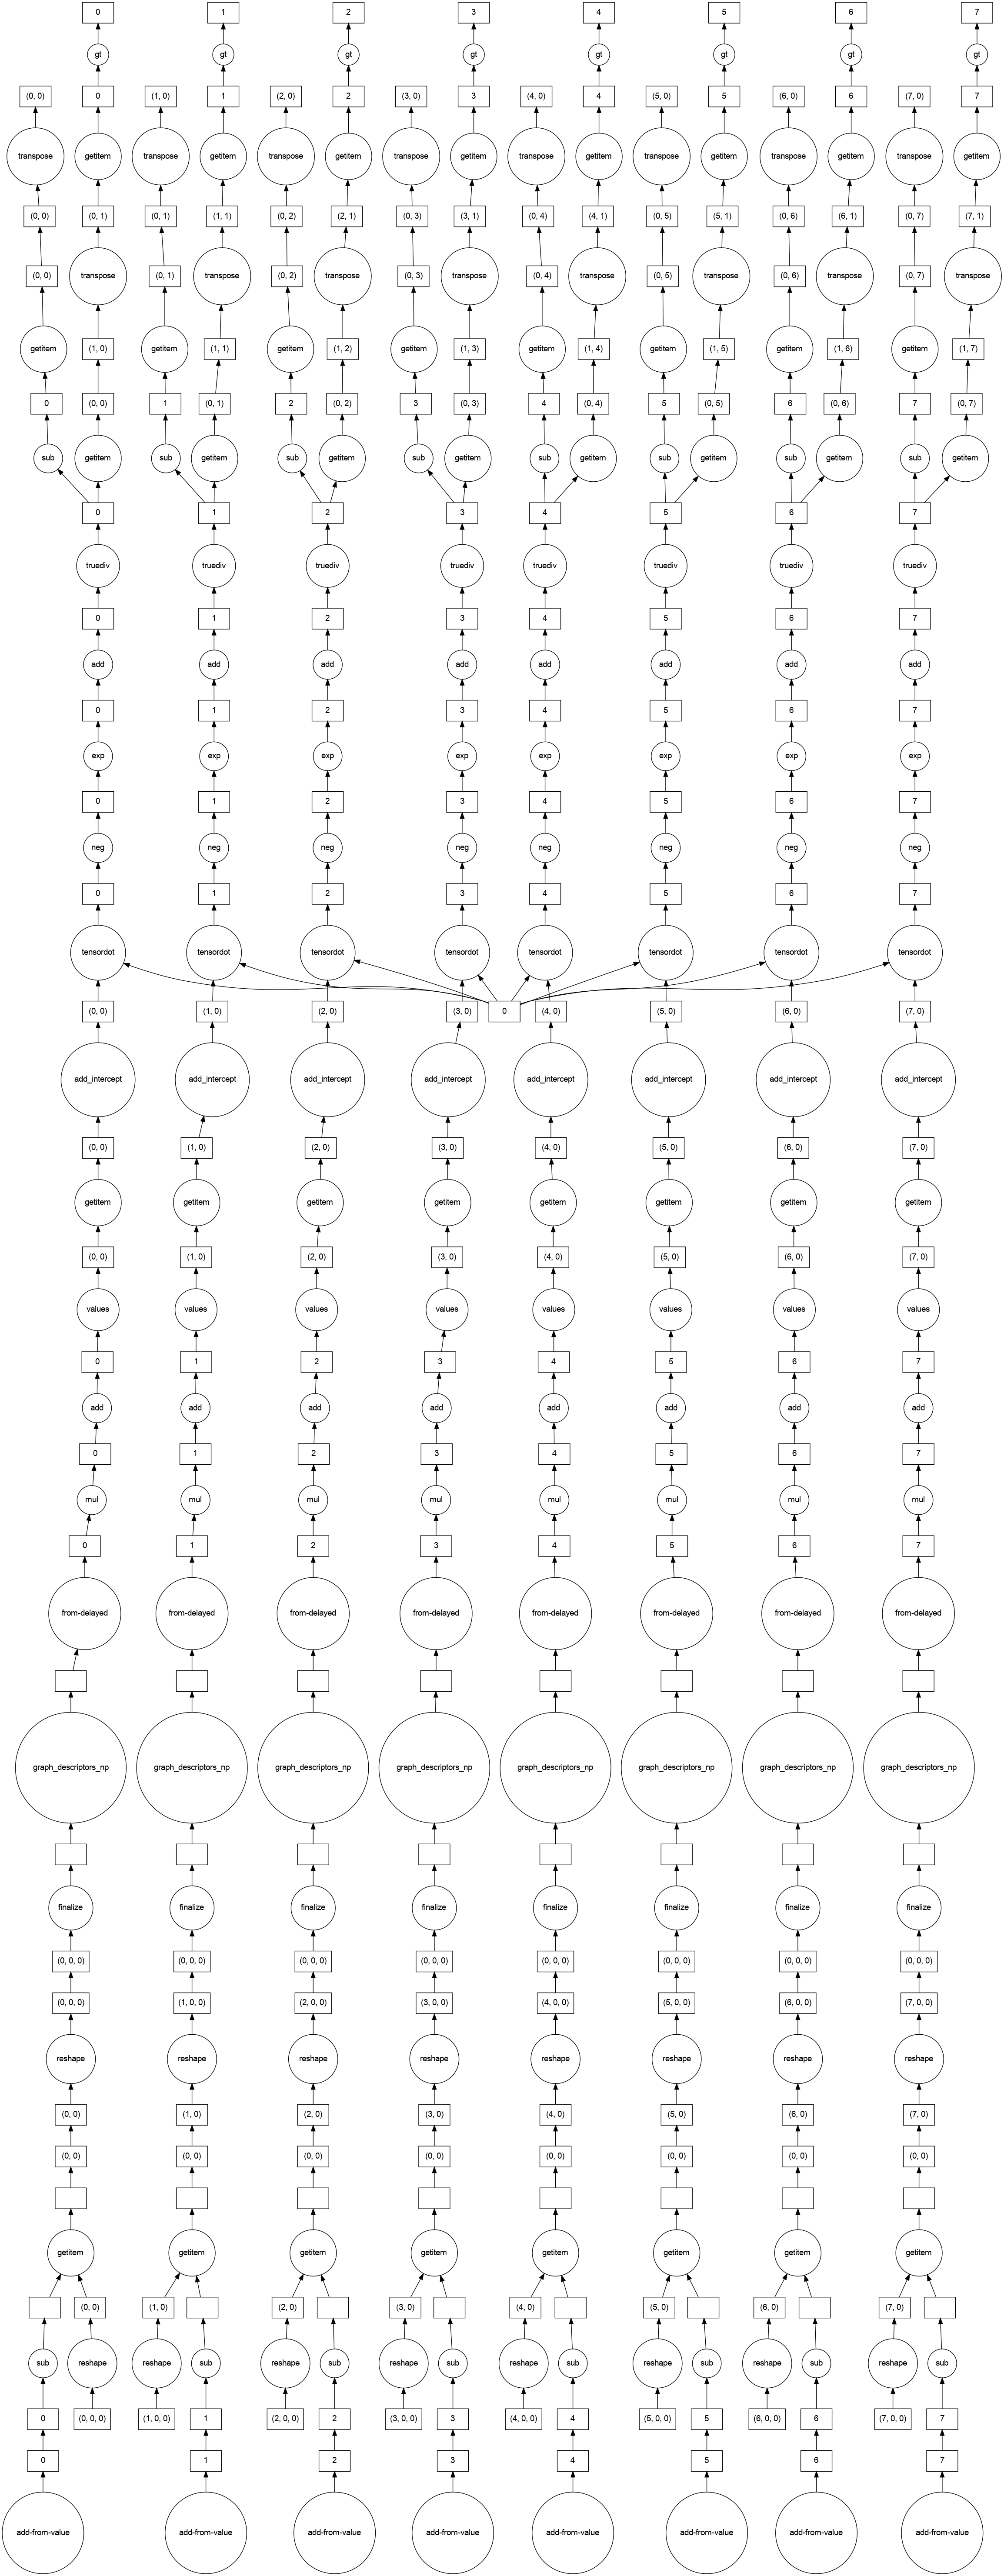

In [27]:
# NBVAL_SKIP

y_predict.visualize()